# YAML File Inputs
This basic example will walk you through understanding the three main classes required to build and exercise equivalent circuit models using this package. The three classes as the `Model`, `Experiment`, and `StepSolution` or `CylceSolution` classes. Models hold parameters associated with defining the battery circuit, experiments list a series of sequential steps that define a test protocol or duty cycle, and the solution classes provide an interface to access, manipulate, and/or plot the solution.

## Import Modules

In [1]:
import thevenin
import numpy as np

## Construct a Model
The model class can be constructed using either a '.yaml' file or a dictionary that specifies all keyword arguments shown in the documentation (`help(thevenin.Model)`). A default '.yaml' file is read in when no input is provided. This is simply for convenience to help users get up and going as quickly as possible. However, you should learn how to write your own '.yaml' file or dictionary input if you would like to use this package to its fullest extent. 

The '.yaml' format is very similar to building a dictionary in Python. Use the default 'params.yaml' file given below as a template for your own files. Note that the open circuit voltage `ocv` and circuit elements (`R0`, `R1`, and `C1`) must be input as a `Callable` with the correct inputs in the correct order, i.e., `f(soc: float) -> float` for `ocv` and `f(soc: float, T_cell: float) -> float` for all RC elements. The inputs represent the state of charge (`soc`, -) and cell temperature (`T_cell`, K). Resistor and capacitor outputs should be in Ohm and F, respectively. Since '.yaml' files do not natively support python functions, this package uses a custom `!eval` constructor to interpret functional parameters. The `!eval` constructor should be followed by a pipe `|` so that the interpreter does not get confused by the colon in the `lambda` expression. `np` expressions and basic math are also supported when using the `!eval` constructor.

```yaml
num_RC_pairs: 1
soc0: 1.
capacity: 75.
mass: 1.9
isothermal: False
Cp: 745.
T_inf: 300.
h_therm: 12.
A_therm: 1.
ocv: !eval | 
    lambda soc:   84.6*soc**7 - 348.6*soc**6 + 592.3*soc**5 - 534.3*soc**4 \
                + 275.*soc**3 - 80.3*soc**2 + 12.8*soc + 2.8
R0: !eval |
    lambda soc, T_cell: 1e-4 + soc/1e5 - T_cell/3e7
R1: !eval |
    lambda soc, T_cell: 1e-5 + soc/1e5 - T_cell/3e7
C1: !eval |
    lambda soc, T_cell: 1e4 + soc*1e4 + np.exp(T_cell/300.)
```

Although this example only uses a single RC pair, `num_RC_pairs` can be as low as 0 and can be as high as $N$. The number of defined `Rj` and `Cj` elements in the '.yaml' file should be consistent with `num_RC_pairs`. For example, if `num_RC_pairs=0` then only `R0` should be defined, with no other resistors or capacitors. However, if `num_RC_pairs=3` then the user should specify `R0`, `R1`, `R2`, `R3`, `C1`, `C2`, and `C3`. Note that the series resistor element `R0` is always included, even when there are no RC pairs. 

In [2]:
model = thevenin.Model()


[thevenin UserWarning] Using the default parameter file 'params.yaml'.



When using the default parameters, a warning will always print. This is to ensure the user is running with their preferred inputs. In the case that a user has a file by the same name, the package will take the default as its preference. Be sure to specify the local or absolute path in this case, e.g., `./params.yaml`, or simply rename your file.

## Build an Experiment
Experiments are built using the `Experiment` class. An experiment starts out empty and is then constructed by adding a series of current-, voltage-, or power-controlled steps. Each step requires knowing the control mode/units, the control value, a relative time span, and limiting criteria (optional). Control values can be specified as either constants or dynamic profiles with sinatures like `f(t: float) -> float` where `t` is the relative time of the new step, in seconds. The experiment below discharges at a nominal 1C rate for up to 1 hour. A limit is set such that if the voltage hits 3 V then the next step is triggered early. Afterward, the battery rests for 10 min before charging at 1C for 1 hours or until 4.3 V is reached. The remaining three steps perform a voltage hold at 4.3 V for 10 min, a constant power profile of 200 W for 1 hour or until 3.8 V is reached, and a sinusoidal voltage load for 10 min centered around 3.8 V.

Note that the time span for each step is constructed as `(t_max: float, dt: float)` which is used to determine the time array as `tspan = np.arange(0., t_max + dt, dt)`. You can also construct a time array given `(t_max: float, Nt: int)` by using an integer instead of a float in the second position. In this case, `tspan = np.linspace(0., t_max, Nt)`. To learn more about building an experiment, including which limits are allowed and/or how to adjust solver settings on a per-step basis, see the documentation `help(thevenin.Experiment)`.

In [3]:
dynamic_load = lambda t: 10e-3*np.sin(2.*np.pi*t / 120.) + 3.8

expr = thevenin.Experiment(max_step=10.)
expr.add_step('current_A', 75., (3600., 1.), limits=('voltage_V', 3.))
expr.add_step('current_A', 0., (600., 1.))
expr.add_step('current_A', -75., (3600., 1.), limits=('voltage_V', 4.3))
expr.add_step('voltage_V', 4.3, (600., 1.))
expr.add_step('power_W', 200., (3600., 1.), limits=('voltage_V', 3.8))
expr.add_step('voltage_V', dynamic_load, (600., 1.))

## Run the Experiment
Experiments are run using either the `run` method, as shown below, or the `run_step` method. The difference between the two is that the `run` method will run all experiment steps with one call. If you would prefer to run the discharge first, perform an analysis, and then run the rest, etc. then you will want to use the `run_step` method. In this case, you should always start with step 0 and then run the following steps in order. When you use `run_step` the models internal state is saved at the end of each step. Therefore, after all steps have been run, you should run the `pre` method to pre-process the model back to its original initial state. All of this is handled automatically in the `run` method.

Regardless of how you run your experiment, the return value will be a solution instance. Solution instances each contain a `vars` attribute which contains a dictionary of the output variables. Keys are generally self descriptive and include units where applicable. To quickly plot any two variables against one another, use the `plot` method with the two keys of interest specified for the `x` and `y` variables of the figure. Below, time (in hours) is plotted against voltage.

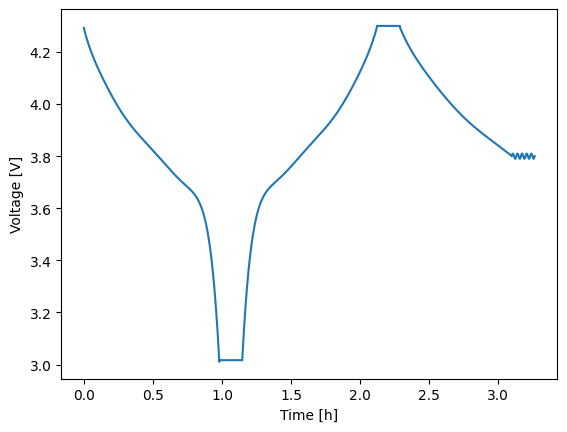

In [4]:
sol = model.run(expr)
sol.plot('time_h', 'voltage_V')

To run step-by-step, perform the following.

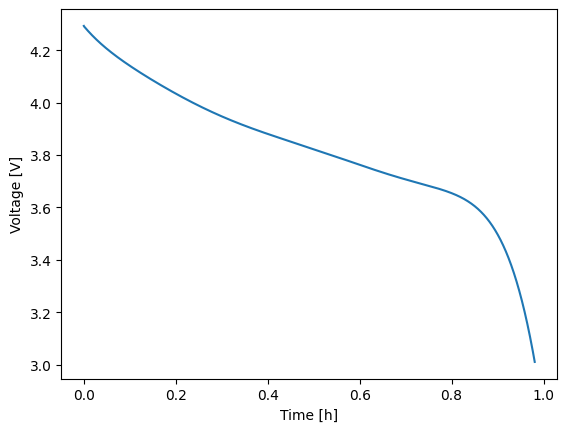

In [5]:
# Run each index, starting with 0
solns = []
for i in range(expr.num_steps):
    solns.append(model.run_step(expr, i))
    
# Re-run the pre-processor in case you'd like to run another experiment
model.pre()
    
# Look at the first step solution (i.e., the 1C discharge)
solns[0].plot('time_h', 'voltage_V')

If you run an experiment step-by-step, you can also manually stitch them together into a `CycleSolution` once you are finished. Alternatively, if you have a `CycleSolution`, you can pull a single `StepSolution` or a subset of the `CycleSolution` using the `get_steps` method. See below for an example.

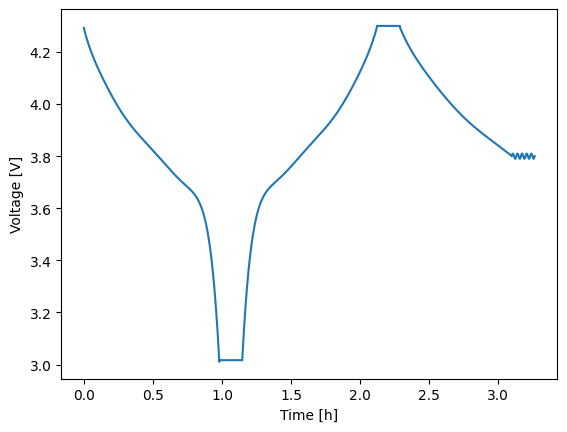

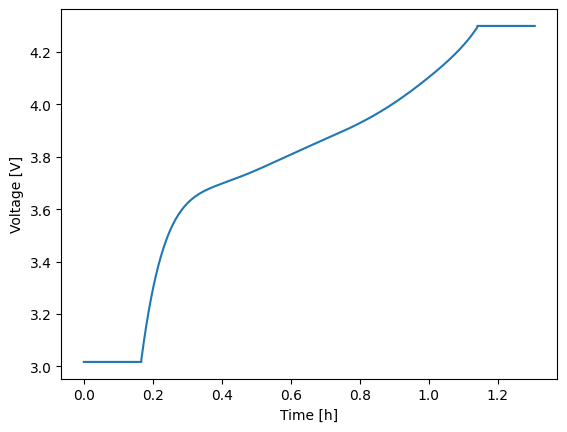

In [6]:
# Stitch the step solutions together
cycle_soln = thevenin.CycleSolution(*solns)
cycle_soln.plot('time_h', 'voltage_V')

# Pull steps 1--3 (inclusive)
some_steps = cycle_soln.get_steps((1, 3))
some_steps.plot('time_h', 'voltage_V')